In [1]:
import ast

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import wandb

In [2]:
api = wandb.Api()

In [3]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [14]:
def get_experiment_data(filters, name):
    runs = api.runs("bartekcupial/sf2_nethack", filters=filters)
    data = []
    for run in runs:
        try:
            artifact = api.artifact(f"bartekcupial/sf2_nethack/run-{run.id}-table_results:v0")
            artifact.download()
            table = artifact.get("table_results")
            df = table.get_dataframe()
            df["seed"] = run.config["seed"]
            df["train/env_steps"] = run.summary_metrics["train/env_steps"]
            df["name"] = name
            df["exp_tag"] = ast.literal_eval(run.config["exp_tags"])[0]
            data.append(df)
        except Exception as e:
            pass

    df = pd.concat(data, axis=0).reset_index()
    df.reset_index(drop=True, inplace=True)
    return df

In [15]:
appo = get_experiment_data({"config.exp_tags": "['2024_02_01_eval_APPO']"}, "appo")
appo_t = get_experiment_data({"config.exp_tags": "['2024_02_01_eval_APPO-T']"}, "appo_t")
appo_ks_t = get_experiment_data({"config.exp_tags": "['2024_02_01_eval_APPO-KS-T']"}, "appo_ks_t")
appo_bc_t = get_experiment_data({"config.exp_tags": "['2024_02_01_eval_APPO-BC-T']"}, "appo_bc_t")
appo_ewc_t = get_experiment_data({"config.exp_tags": "['2024_02_01_eval_APPO-EWC-T']"}, "appo_ewc_t")

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb

In [16]:
data = pd.concat([appo, appo_t, appo_ks_t, appo_bc_t, appo_ewc_t], axis=0)

In [53]:
data.head()

,index,reward,len,score,turns,dlvl,max_hitpoints,max_energy,armor_class,experience_level,...,scout_score,sokobanfillpit_score,staircase_pet_score,staircase_score,episode_number,true_objective,seed,train/env_steps,name,exp_tag
0,0,850.0,7701.0,850,4932,1,41,19,4,5,...,367,0,0,16,0,850.0,1,500015104,appo,2024_02_01_eval_APPO
1,1,264.0,8786.0,264,1742,1,18,24,4,3,...,328,0,0,0,0,264.0,1,500015104,appo,2024_02_01_eval_APPO
2,2,147.0,10065.0,147,4236,1,22,11,4,2,...,155,0,0,0,0,147.0,1,500015104,appo,2024_02_01_eval_APPO
3,3,1316.0,11534.0,1316,10334,1,49,31,4,6,...,350,0,0,15,0,1316.0,1,500015104,appo,2024_02_01_eval_APPO
4,4,936.0,12394.0,936,6438,1,36,32,4,5,...,355,0,0,0,0,936.0,1,500015104,appo,2024_02_01_eval_APPO


In [108]:
mask = (data["name"] == "appo_bc_t") & (data["seed"] == 0)

In [110]:
data = data[~mask]

### Density of rewards

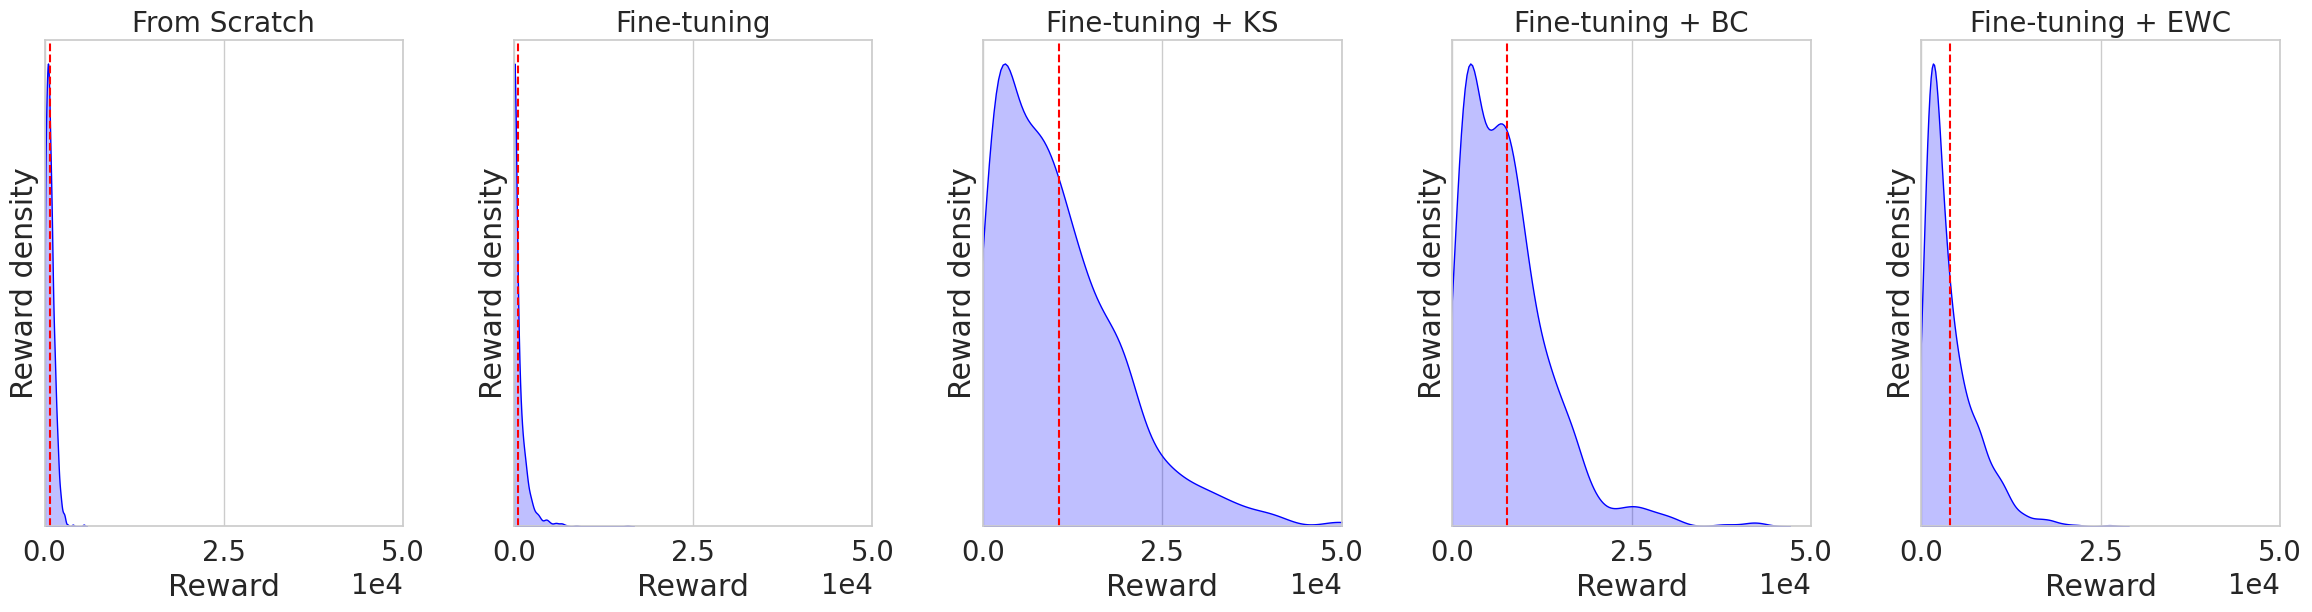

In [111]:
sns.set(font_scale=1.8)
sns.set_style("whitegrid")

n_rows = 1
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 7))
axes = axes.flatten()

sns.set(font_scale=3)
sns.set_style('whitegrid')

method_translator = {
    "appo": "From Scratch",
    "appo_t": "Fine-tuning",
    "appo_ks_t": "Fine-tuning + KS",
    "appo_bc_t": "Fine-tuning + BC",
    "appo_ewc_t": "Fine-tuning + EWC",
}

eval = "reward"

for e, (ax, (method, method_name)) in enumerate(zip(axes, method_translator.items())):
    method_data = data[data["name"] == method]

    # sns.histplot(method_data[eval], kde=False, color='blue', edgecolor='black', ax=ax)
    sns.kdeplot(method_data[eval], color='blue', fill=True, ax=ax)
    ax.axvline(x=method_data[eval].mean(), color='red', linestyle='--', label='Mean')

    # ax.set_ylim(0.5, 9.0)
    ax.set_xlim(0, 50000.0)
    
    ax.set_title(f"{method_name}", fontsize=20)
    ax.set_ylabel("Reward density")
    ax.set_xlabel("Reward")
    # ax.scatter(method_data[eval_x].mean(), method_data[eval_y].mean(), marker='X', color='white', s=100)  # Adjust color and size as needed
    
    ax.set_yticks([])
    # ax.set_yticks(ticks=range(1, 9 + 1, 2))
    # ax.set_xticks(ticks=range(0, 50000 + 1, 10000))
    
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
plt.tight_layout()
plt.show()

### Tabular

In [112]:
data.columns

Index(['index', 'reward', 'len', 'score', 'turns', 'dlvl', 'max_hitpoints',
       'max_energy', 'armor_class', 'experience_level', 'experience_points',
       'eating_score', 'gold_score', 'scout_score', 'sokobanfillpit_score',
       'staircase_pet_score', 'staircase_score', 'episode_number',
       'true_objective', 'seed', 'train/env_steps', 'name', 'exp_tag'],
      dtype='object')

In [113]:
columns = ['score', 'turns', 'len', 'dlvl', 'experience_level', 'experience_points', 'eating_score', 'gold_score', 'scout_score', 'sokobanfillpit_score', 'staircase_score', "name"]

In [115]:
data[columns].groupby("name").mean()

,score,turns,len,dlvl,experience_level,experience_points,eating_score,gold_score,scout_score,sokobanfillpit_score,staircase_score
name,,,,,,,,,,,
appo,776.712000,6696.827000,13539.178000,1.064000,4.066000,171.032000,5862.556000,5.340000,370.61700,0.000,25.170000
appo_bc_t,7610.995000,22895.161250,34560.110000,1.782500,7.306250,1670.395000,21995.738750,582.337500,959.34625,0.000,69.890000
appo_ewc_t,3976.597000,16725.276000,35018.961000,1.414000,6.285000,886.524000,15896.451000,217.118000,719.70300,0.000,81.744000
appo_ks_t,10588.959000,24436.596000,38635.880000,2.657000,7.734000,2500.852000,23705.561000,857.202000,1551.18000,0.039,90.098000
appo_t,647.701772,7756.983268,13352.136811,1.024606,2.734252,131.735236,7161.199803,9.262795,149.69685,0.000,19.937992


In [116]:
print(data[columns].groupby("name").mean().to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & score & turns & len & dlvl & experience_level & experience_points & eating_score & gold_score & scout_score & sokobanfillpit_score & staircase_score \\
name &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
appo & 776.71 & 6696.83 & 13539.18 & 1.06 & 4.07 & 171.03 & 5862.56 & 5.34 & 370.62 & 0.00 & 25.17 \\
appo_bc_t & 7610.99 & 22895.16 & 34560.11 & 1.78 & 7.31 & 1670.39 & 21995.74 & 582.34 & 959.35 & 0.00 & 69.89 \\
appo_ewc_t & 3976.60 & 16725.28 & 35018.96 & 1.41 & 6.29 & 886.52 & 15896.45 & 217.12 & 719.70 & 0.00 & 81.74 \\
appo_ks_t & 10588.96 & 24436.60 & 38635.88 & 2.66 & 7.73 & 2500.85 & 23705.56 & 857.20 & 1551.18 & 0.04 & 90.10 \\
appo_t & 647.70 & 7756.98 & 13352.14 & 1.02 & 2.73 & 131.74 & 7161.20 & 9.26 & 149.70 & 0.00 & 19.94 \\
\bottomrule
\end{tabular}



In [117]:
data[columns + ["seed"]].groupby(["name", "seed"]).mean() 

score         turns           len   dlvl  \
name       seed                                                    
appo       0       966.230000   8167.515000  17025.685000  1.055   
           1       875.200000   6546.910000  16628.600000  1.120   
           2       763.465000   7317.080000  13200.530000  1.035   
           3       664.280000   6328.910000  14308.310000  1.070   
           4       614.385000   5123.720000   6532.765000  1.040   
appo_bc_t  1      5968.670000  20151.215000  28185.790000  1.715   
           2      6833.030000  22545.645000  33435.810000  1.520   
           3      7819.650000  22492.640000  34208.085000  2.015   
           4      9822.630000  26391.145000  42410.755000  1.880   
appo_ewc_t 0      3813.105000  16531.390000  39369.615000  1.360   
           1      3793.245000  16064.405000  37690.395000  1.465   
           2      4128.150000  17932.265000  28893.920000  1.280   
           3      4312.115000  17137.430000  33706.500000  1.470   
           4      3836.370000  15960.890000  35434.375000  1.495   
appo_ks_t  0     10957.420000  26182.860000  42518.155000  2.075   
           1     11676.425000  24665.765000  38761.420000  3.065   
           2     10498.020000  23966.935000  37276.190000  2.835   
           3      9867.580000  23629.975000  37219.755000  2.415   
           4      9945.350000  23737.445000  37403.880000  2.895   
appo_t     0       961.920000  14026.050000  19787.285000  1.045   
           1         0.528846      4.447115    162.331731  1.000   
           2      1717.195000  13051.180000  28805.600000  1.070   
           3         4.096154     10.062500    166.389423  1.000   
           4       606.400000  12313.155000  18894.100000  1.010   

                 experience_level  experience_points  eating_score  \
name       seed                                                      
appo       0                4.325         222.160000   7338.645000   
           1                4.220         192.930000   5784.655000   
           2                4.130         177.645000   6543.050000   
           3                3.855         131.935000   5279.330000   
           4                3.800         130.490000   4367.100000   
appo_bc_t  1                6.945        1305.010000  19290.720000   
           2                7.065        1476.305000  21511.445000   
           3                7.475        1682.305000  21596.845000   
           4                7.740        2217.960000  25583.945000   
appo_ewc_t 0                6.220         854.825000  15756.950000   
           1                6.200         841.385000  15231.550000   
           2                6.250         921.975000  16964.025000   
           3                6.420         944.080000  16355.305000   
           4                6.335         870.355000  15174.425000   
appo_ks_t  0                7.725        2488.605000  25340.565000   
           1                7.925        2738.560000  23933.305000   
           2                7.750        2680.405000  23291.170000   
           3                7.600        2274.215000  22948.935000   
           4                7.670        2322.475000  23013.830000   
appo_t     0                3.885         197.540000  13143.225000   
           1                1.000           0.086538      0.000000   
           2                4.855         362.190000  12174.475000   
           3                1.000           0.884615    207.807692   
           4                3.070         108.475000  10845.075000   

                  gold_score  scout_score  sokobanfillpit_score  \
name       seed                                                   
appo       0        3.995000   371.535000                 0.000   
           1        4.920000   357.510000                 0.000   
           2        5.310000   348.305000                 0.000   
           3        5.695000   396.955000                 0.000   
           4        6.780000   3

### Density of dlvl vs turns

In [119]:
df = pd.read_csv("notebooks/cloned_expert_1024_human_monk.csv")
df["name"] = "pretrained"
df["exp_tag"] = "pretrained"
df["index"] = 0
df["train/env_steps"] = 0
df["seed"] = 0

In [121]:
data = pd.concat([df, data])

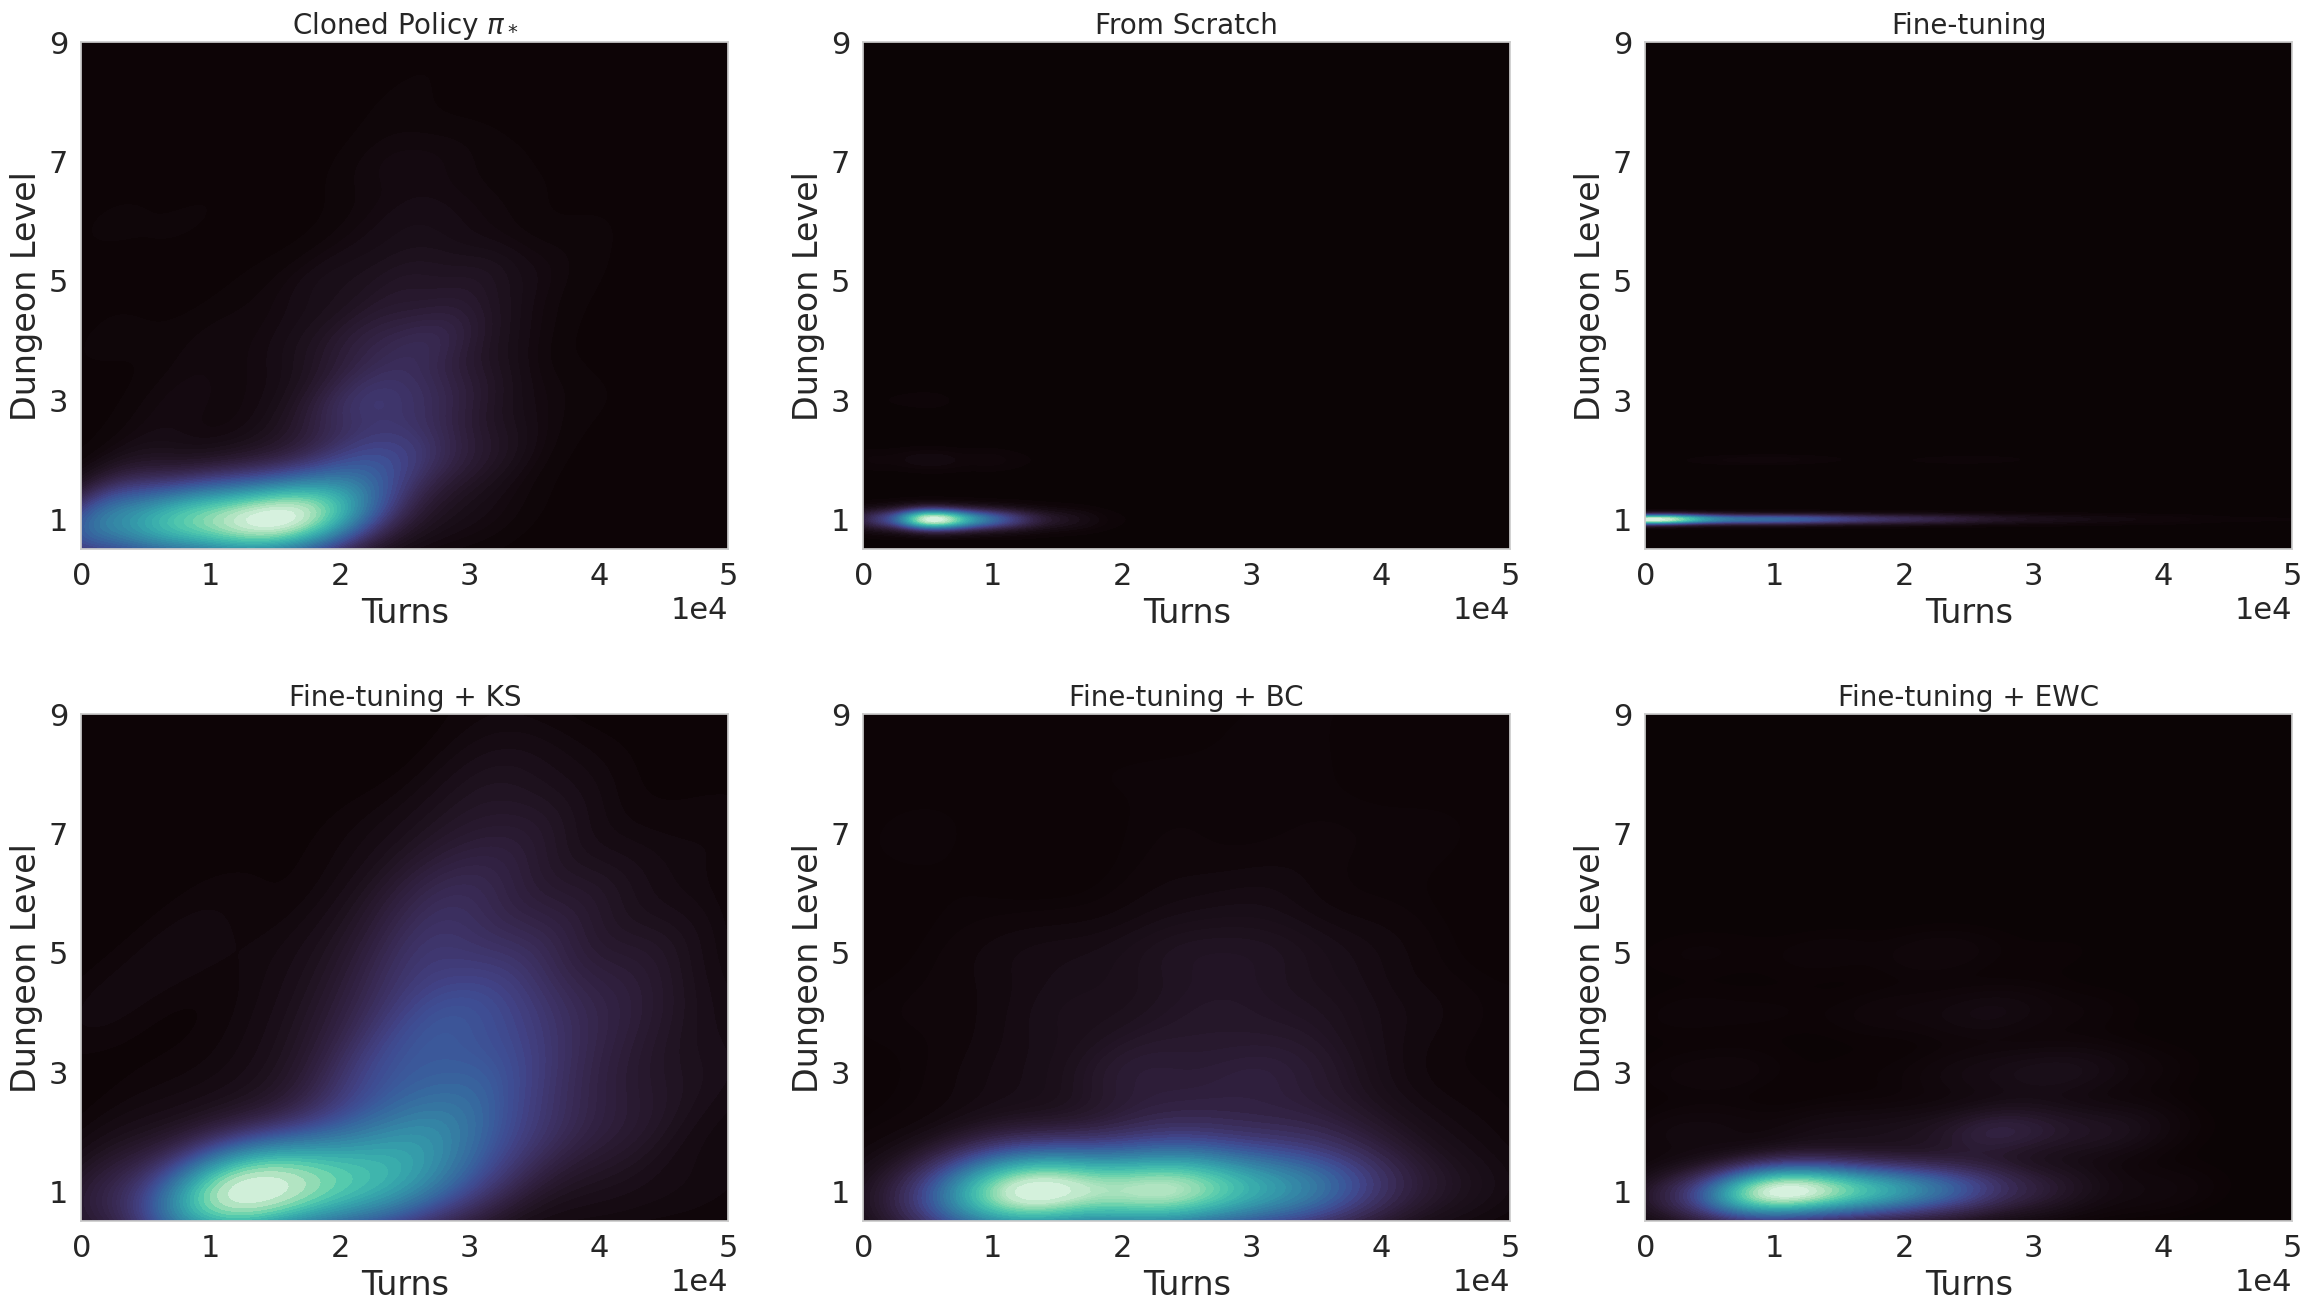

In [132]:
sns.set(font_scale=2)
sns.set_style("whitegrid")

n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 14))
axes = axes.flatten()

sns.set(font_scale=3)
sns.set_style('whitegrid')

method_translator = {
    # "autoascend": "AutoAscend",
    "pretrained": "Cloned Policy $\pi_*$",
    "appo": "From Scratch",
    "appo_t": "Fine-tuning",
    "appo_ks_t": "Fine-tuning + KS",
    "appo_bc_t": "Fine-tuning + BC",
    "appo_ewc_t": "Fine-tuning + EWC",
}

eval_y = "dlvl"
eval_x = "turns"

for e, (ax, (method, method_name)) in enumerate(zip(axes, method_translator.items())):
    method_data = data[data["name"] == method]

    sns.kdeplot(x=eval_x, y=eval_y, data=method_data, thresh=0, levels=50, cmap="mako", fill=True, ax=ax, label=method_name)
    ax.set_ylim(0.5, 9.0)
    ax.set_xlim(0, 50000.0)
    
    ax.set_title(f"{method_name}", fontsize=20)
    ax.set_ylabel("Dungeon Level")
    ax.set_xlabel("Turns")
    ax.set_facecolor(sns.color_palette("mako", as_cmap=True)(0))
    # ax.scatter(method_data[eval_x].mean(), method_data[eval_y].mean(), marker='X', color='white', s=100)  # Adjust color and size as needed
    
    ax.set_yticks(ticks=range(1, 9 + 1, 2))
    ax.set_xticks(ticks=range(0, 50000 + 1, 10000))
    
    ax.grid(color='white', linestyle='-', linewidth=0, alpha=0)
    
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
plt.tight_layout()
plt.show()